# Azure OpenAI Assistants - Code Interpreter

Code Interpreter allows the Assistants API to write and run Python code in a sandboxed execution environment. With Code Interpreter enabled, your Assistant can run code iteratively to solve challenging code, math, and data analysis problems. When your Assistant writes code that fails to run, it can iterate on this code by modifying and running different code until the code execution succeeds.

This notebook will find answers to a data set:
1. If 1 row in the dataset is 1 sighthing, what's our total sightings?
2. Which state has the most sightings?
3. Which season has the most sightings?
4. What are the top 10 years with the most sightings?
5. How many sightings did we have for Washington state in the year 2000?

Answers:
1. 5021
2. Washington (601)
3. Summer
4. 2004, 2005, 2006, 2003, 2000, 2007, 2008, 2012, 2001, 2011
5. 28

## Load Azure Configuration

In [1]:
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings("ignore")

# Load environment variables from .env file

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Step 1-2:
1. Create an Assistant
2. Create a Thread

In [2]:
from openai import AzureOpenAI
import time

# Create an AzureOpenAI client
client = AzureOpenAI(
  azure_endpoint = azure_openai_endpoint,
  api_key= azure_openai_key,
  api_version=azure_openai_api_version
)

# Create a file
file = client.files.create(
  file=open("../Data/assistant/bigfootsightings.csv", "rb"),
  purpose='assistants'
)

# STEP 1: Create an assistant
assistant = client.beta.assistants.create(
  model=azure_openai_deployment,
  name="bigfootsightings",
  instructions="""You are an assistant answering questions about bigfootsightings dataset.""",
  tools=[{"type":"code_interpreter"}],
  tool_resources={"code_interpreter":{"file_ids":[file.id]}},
  temperature=1,
  top_p=1, 
)

# STEP 2: Create a thread
thread = client.beta.threads.create()


## Step 3-6: Helper Function
3. Add a message to the thread
4. Run the Assistant
5. Check the Run Status
6. Display the Assistant's Response

In [3]:
from PIL import Image

def run_assistant(user_question):
  PROMPT_ADD = """
  - **ALWAYS** before giving the Final Answer, try another method.
  Then reflect on the answers of the two methods you did and ask yourself
  if it answers correctly the original question.
  If you are not sure, try another method.
  - If the methods tried do not give the same result,reflect and
  try again until you have two methods that have the same result.
  - If you still cannot arrive to a consistent result, say that
  you are not sure of the answer.
  - If you are sure of the correct answer, create a beautiful
  and thorough response using Markdown.
  - **DO NOT MAKE UP AN ANSWER OR USE PRIOR KNOWLEDGE,
  ONLY USE THE RESULTS OF THE CALCULATIONS YOU HAVE DONE**.
  - **ALWAYS**, as part of your "Final Answer", explain how you got
  to the answer on a section that starts with: "\n\nExplanation:\n".
  In the explanation, mention the column names that you used to get
  to the final answer and provide the python code you used.
  """

  # STEP 3: Add a user question to the thread
  messages = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=PROMPT_ADD + user_question
  )

  # STEP 4: Run the thread
  run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
  )

  # STEP 5: Check the run status
  # Looping until the run completes or fails
  while run.status in ['queued', 'in_progress', 'cancelling']:
    time.sleep(1)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    
    #display run status
    print(run.status)

    if run.status == 'completed':
      messages = client.beta.threads.messages.list(thread_id=thread.id)
      # STEP 6: Display the Assistant's Response
      content_block = messages.data[0].content[0]
      
      # Check if the content block has a text attribute
      if hasattr(content_block, 'text') and content_block.text.value is not None:
        print(content_block.text.value)
        
        # Check if the content block has an annotations attribute
        if hasattr(content_block.text, 'annotations') and len(content_block.text.annotations) > 0:
          # enter the file_id inside content example: "assistant-fYrZ85PwbViKU9mrVoE8dqBO"
          file_id = content_block.text.annotations[0].file_path.file_id
          image_data = client.files.content(file_id)
          image= image_data.write_to_file("img_code_interpreter.png")
          
          # Display the image in the default image viewer
          image = Image.open("img_code_interpreter.png")
          image.show()
      
      # Check if the content block has an image_file attribute
      if hasattr(content_block, 'image_file'):
        file_id = content_block.image_file.file_id
        image_data = client.files.content(file_id)
        image= image_data.write_to_file("img_code_interpreter.png")
          
        # Display the image in the default image viewer
        image = Image.open("img_code_interpreter.png")
        image.show()

    elif run.status == 'requires_action':
      # the assistant requires calling some functions
      # and submit the tool outputs back to the run
      pass

    elif run.status == "failed":
        print(run.last_error)
        
    else:
      pass
    


In [4]:
user_query = """If 1 row in the dataset is 1 sighting, which state has the most sightings? 
Provide the number of sightings in that state"""
run_assistant(user_query)

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed
### Final Answer

The state with the most Bigfoot sightings is **Washington**, with a total of **601 sightings**.

### Explanation:
To determine which state has the most sightings, I first counted the number of sightings from the column **`state`** using two different methods. 

1. **First Method**: I used the `value_counts()` function to tally how many times each state appeared in the dataset. This produced a series from which I extracted the state with the maximum count.

   ```python
   sightings_per_state = data['state'].value_counts()
   most_sightings_state = sightings_per_state.idxmax()
   most_sightings_count = sightings_per_state.max()
   ```

2. **Second Method**: I utilized `groupby()` along with `size()` to calculate the count of sightings per state and then identified the state with the highest count from the resulting Da

## Step 7: Appending Messages to the thread

In [5]:
user_query ="""Which season has the most sightings?"""
run_assistant(user_query)

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed
### Final Answer

The season with the most Bigfoot sightings is **Summer**, with a total of **1867 sightings**.

### Explanation:
To determine which season has the most sightings, I used two different methods based on the column **`season`** in the dataset.

1. **First Method**: I applied the `value_counts()` function on the **`season`** column to count how many sightings occurred in each season. I then identified the season with the maximum count.

   ```python
   sightings_per_season = data['season'].value_counts()
   most_sightings_season = sightings_per_season.idxmax()
   most_sightings_season_count = sightings_per_season.max()
   ```

2. **Second Method**: I grouped the data by **`season`** and counted the number of sightings in each season using `size()` followed by `reset_index()`. I then extracted the season with the highest count.

   ```python
   sightings_count_by_season = data.groupby('season'

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed
### Final Answer

The top 10 years with the most Bigfoot sightings are as follows:

| Year | Sightings |
|------|-----------|
| 2004 | 241       |
| 2005 | 209       |
| 2006 | 176       |
| 2003 | 152       |
| 2000 | 146       |
| 2007 | 145       |
| 2008 | 141       |
| 2012 | 141       |
| 2001 | 131       |
| 2011 | 121       |

Additionally, I have created a bar chart visualizing these sightings. You can download the chart using the link below:

![Top 10 Years with the Most Bigfoot Sightings](sandbox:/mnt/data/top_10_years_sightings.png)

### Explanation:
To determine the top 10 years with the most Bigfoot sightings, I followed these steps:

1. **Extracted Year from Date**: I created a new column, **`year`**, by converting the **`date`** column to a datetime format and

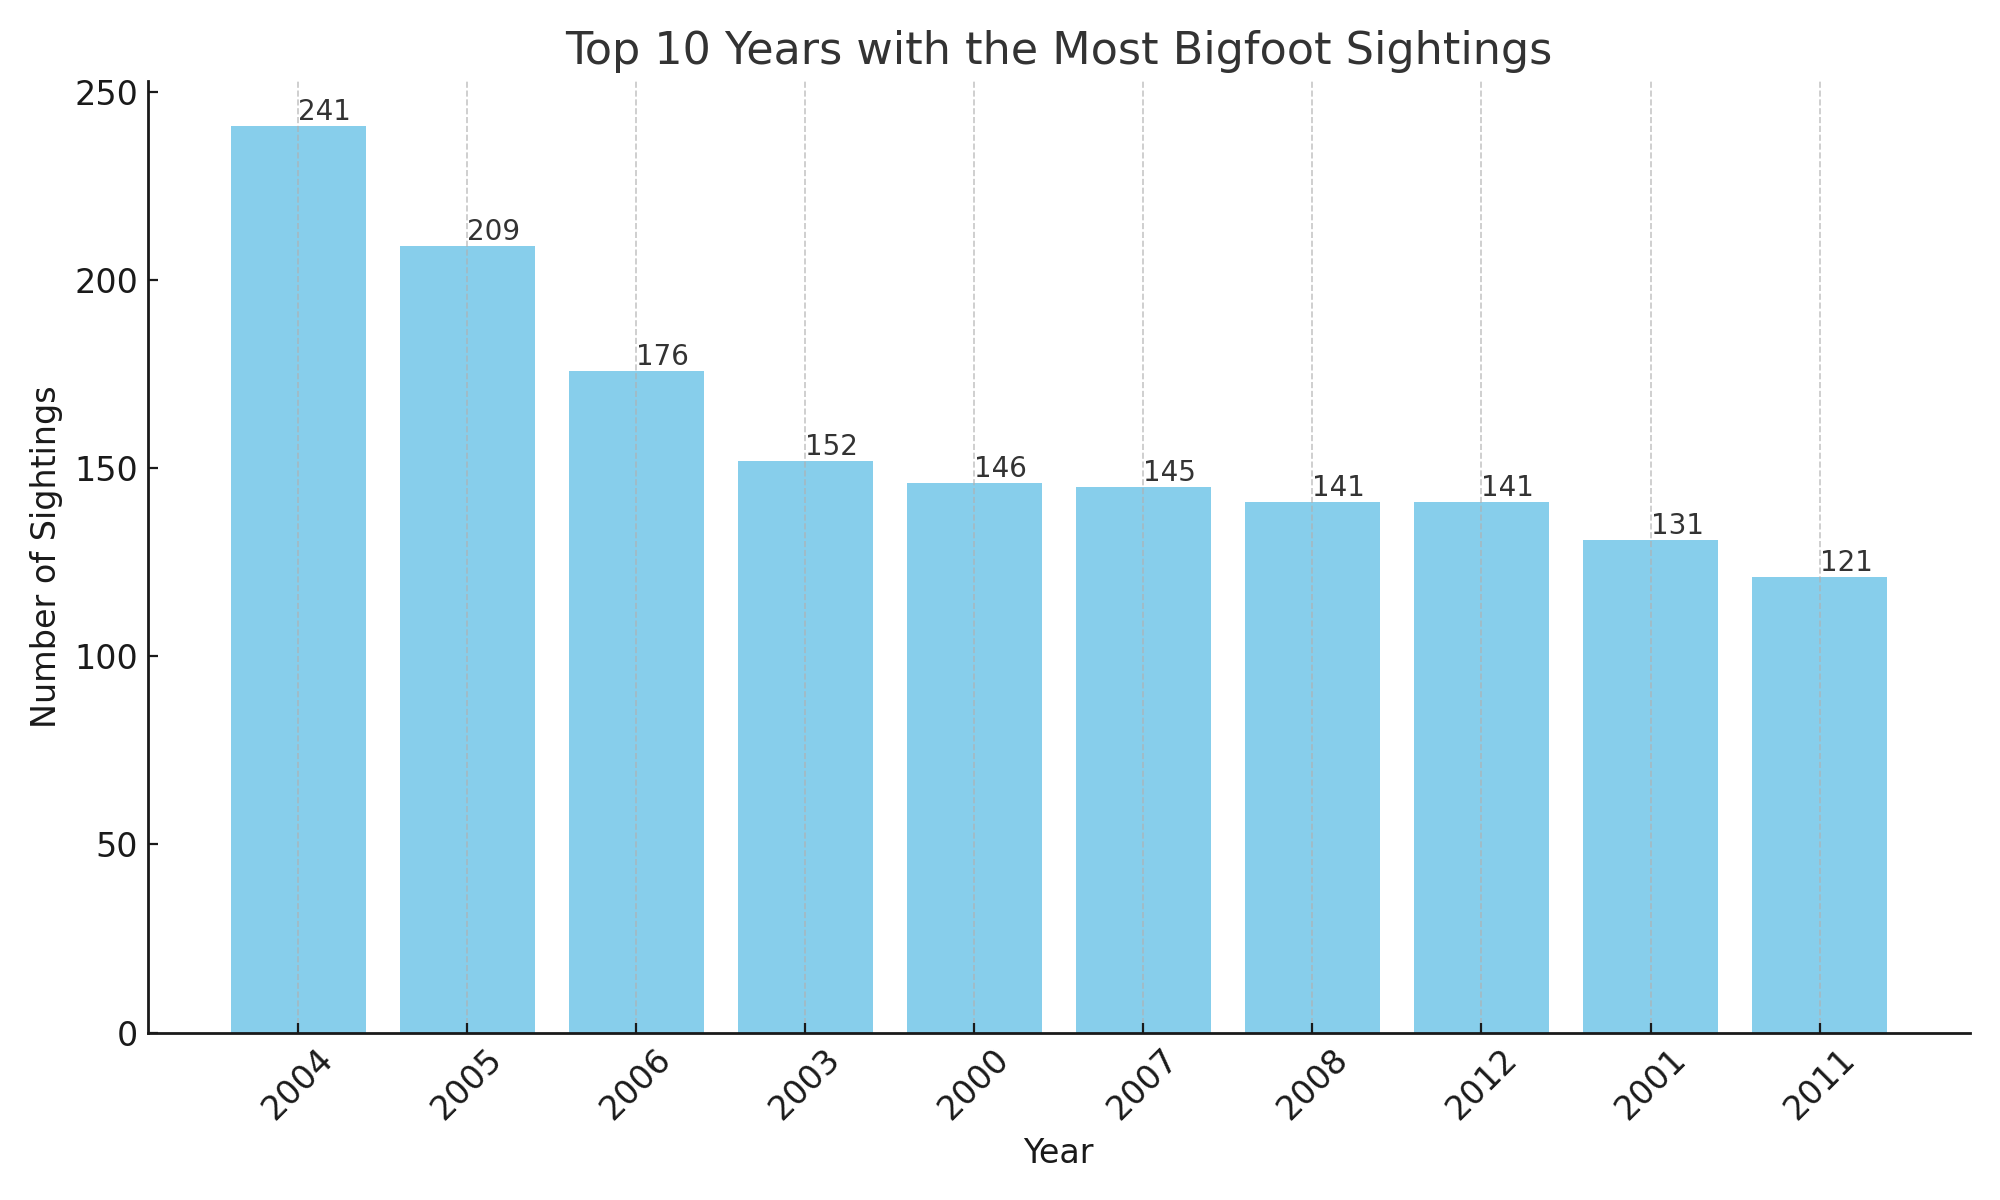

In [6]:
user_query ="""
What are the top 10 years with the most sightings? 
Use the date column and get the year there.
Create a column chart with the sightings in the Y-axis and years in the X-axis and save it to a PNG file and sort by descending order.
Put the value on top of each bar
"""
run_assistant(user_query)

## Delete Resources

In [7]:
response = client.beta.assistants.delete(assistant.id)

In [8]:
client.files.delete(file.id)

FileDeleted(id='assistant-BTfBQfeawo74ECsGvweweR', deleted=True, object='file')